# ABS tutorial 05 (for template fitting)

## foreground cross-correlation models

following 

Planck 2018 results. XI. Polarized dust foregrounds
https://doi.org/10.1051/0004-6361/201832618

and

Polarized galactic synchrotron and dust emission and their correlation
https://doi.org/10.1088/1475-7516/2015/12/020

In [1]:
import numpy as np
import healpy as hp
import matplotlib
import abspy as ap
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
NSIDE = 128
map30 = hp.read_map('./data/TQU_30GHz_r7.fits',field=[0,1,2],dtype=np.float64,verbose=0)
map353 = hp.read_map('./data/TQU_353GHz_r7.fits',field=[0,1,2],dtype=np.float64,verbose=0)
mask = hp.read_map('./data/ali_mask_r7.fits',dtype=bool,verbose=0)

In [3]:
est = ap.pstimator(nside=NSIDE,mask=mask.reshape(1,-1), aposcale=5.0, psbin=20)
ellist, dustamp = est.auto_t(map353[0].reshape(1,-1))[:2]
ellist, syncamp = est.auto_t(map30[0].reshape(1,-1))[:2]

### initialize model with model parameters

model constructor requires

```
ellist : list
    angular mode list
    
freq_ref : float
    
    reference frequency
```

parameter (re)setting is done by function `reset` with a Python dict as input

In [4]:
from abspy.tools.fg_models import syncmodel
from abspy.tools.fg_models import dustmodel

### (partially) reset parameters

In [5]:
s = syncmodel(ellist=list(ellist),freq_ref=30.)
# update synchrotron PS template to model parameters
for i in range(len(ellist)):
    s.reset({s.param_list[i] : syncamp[i]})

if a parameter is not pre-defined inside the `param_list`, then no update will be made

In [6]:
print ('list of pre-defined parameter names')
s.param_list

list of pre-defined parameter names


['amp_s_11.5',
 'amp_s_31.5',
 'amp_s_51.5',
 'amp_s_71.5',
 'amp_s_91.5',
 'amp_s_111.5',
 'amp_s_131.5',
 'amp_s_151.5',
 'amp_s_171.5',
 'amp_s_191.5',
 'amp_s_211.5',
 'amp_s_231.5',
 'amp_s_251.5',
 'amp_s_271.5',
 'amp_s_291.5',
 'amp_s_311.5',
 'amp_s_331.5',
 'amp_s_351.5',
 'amp_s_371.5',
 'beta_s']

In [7]:
s.reset({'beta_s':-2.})
s.reset({'xxx':100})
s.params

{'amp_s_11.5': 746.0074356825078,
 'amp_s_31.5': 933.2833470261152,
 'amp_s_51.5': 1701.3605640786147,
 'amp_s_71.5': 2038.8389502429752,
 'amp_s_91.5': 2427.329633617856,
 'amp_s_111.5': 2995.3825625488967,
 'amp_s_131.5': 4132.004540635241,
 'amp_s_151.5': 4098.265969090354,
 'amp_s_171.5': 5003.471772366568,
 'amp_s_191.5': 5237.676231486928,
 'amp_s_211.5': 5480.780332201542,
 'amp_s_231.5': 5668.938378988525,
 'amp_s_251.5': 4948.897106263535,
 'amp_s_271.5': 5011.257223428095,
 'amp_s_291.5': 4338.6417189831045,
 'amp_s_311.5': 3498.1878935573914,
 'amp_s_331.5': 2449.630773988544,
 'amp_s_351.5': 2109.2449817136676,
 'amp_s_371.5': 1641.8686949766227,
 'beta_s': -2.0}

### illustrate frequency dependencies

this would use the `bandpower` function, which takes a frequency list (in GHz) as input,
the return gives an array in shape 
```
(angular mode size, frequency size, frequency size)
```

- synchrotron

$$ \mathcal{D}^{XX}_\ell(\nu_1,\nu_2) = \mathcal{A}^{XX}_{s,\ell} \left( \frac{\nu_1 \nu_2}{\nu^2_0} \right)^{\beta_s} $$

with Planck reference, $\nu_0 = 30$ GHz.

In [8]:
freq_sample = list(np.arange(10,500,50))
sync_ps = s.bandpower(freq_sample)
sync_ps.shape

(19, 10, 10)

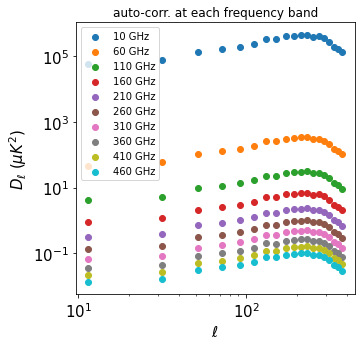

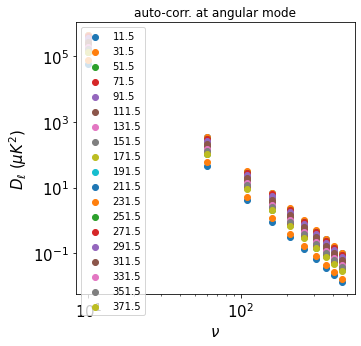

In [9]:
fig,ax = matplotlib.pyplot.subplots(figsize=(5,5))

for j in range(len(freq_sample)):
    ax.scatter(ellist,sync_ps[:,j,j],label=str(freq_sample[j])+' GHz')
    
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'$\ell$',fontsize=15)
ax.set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_title('auto-corr. at each frequency band')
ax.legend(loc=2)

fig,ax = matplotlib.pyplot.subplots(figsize=(5,5))

for i in range(len(ellist)):
    ax.scatter(freq_sample,np.diag(sync_ps[i]),label=str(ellist[i]))
    
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'$\nu$',fontsize=15)
ax.set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_title('auto-corr. at angular mode')
ax.legend(loc=2)

- dust

$$ \mathcal{D}^{XX}_\ell(\nu_1,\nu_2) = \mathcal{A}^{XX}_{d,\ell} \left( \frac{\nu_1 \nu_2}{\nu^2_0} \right)^{\beta_d-2} \frac{B_{\nu_1}(T_d)}{B_{\nu_0}(T_d)} \frac{B_{\nu_2}(T_d)}{B_{\nu_0}(T_d)}$$,

$$\left(\frac{\nu}{\nu_0}\right)^{{\beta_d}-2} \frac{B_\nu(T_d)}{B_{\nu_0}(T_d)} = \left( \frac{\nu}{\nu_0} \right)^{\beta_d+1} \frac{e^{h\nu_0/kT_d}-1}{e^{h\nu/kT_d}-1}$$

with Planck reference, we take $\nu_0=353$ GHz, $T_d = 19.6$ K.

In [10]:
d = dustmodel(ellist=list(ellist),freq_ref=353.)
# update dust PS template to model parameters
for i in range(len(ellist)):
    d.reset({d.param_list[i] : dustamp[i]})
print ('list of pre-defined parameter names')
d.param_list

list of pre-defined parameter names


['amp_d_11.5',
 'amp_d_31.5',
 'amp_d_51.5',
 'amp_d_71.5',
 'amp_d_91.5',
 'amp_d_111.5',
 'amp_d_131.5',
 'amp_d_151.5',
 'amp_d_171.5',
 'amp_d_191.5',
 'amp_d_211.5',
 'amp_d_231.5',
 'amp_d_251.5',
 'amp_d_271.5',
 'amp_d_291.5',
 'amp_d_311.5',
 'amp_d_331.5',
 'amp_d_351.5',
 'amp_d_371.5',
 'beta_d']

In [11]:
d.reset({'beta_d':1.})
d.reset({'xxx':100})
d.params

{'amp_d_11.5': 6463.699957456511,
 'amp_d_31.5': 1849.7639033229948,
 'amp_d_51.5': 2987.362967768661,
 'amp_d_71.5': 3285.1465812899282,
 'amp_d_91.5': 3479.1402435239206,
 'amp_d_111.5': 4524.045818984944,
 'amp_d_131.5': 5336.247101307117,
 'amp_d_151.5': 5564.193803931675,
 'amp_d_171.5': 6203.76514289824,
 'amp_d_191.5': 6169.326883071628,
 'amp_d_211.5': 6146.967098560228,
 'amp_d_231.5': 6600.917748844759,
 'amp_d_251.5': 5638.610014703122,
 'amp_d_271.5': 5561.264184187214,
 'amp_d_291.5': 4889.631451377683,
 'amp_d_311.5': 4029.599346649368,
 'amp_d_331.5': 2988.126630174233,
 'amp_d_351.5': 2657.79409903138,
 'amp_d_371.5': 2106.309177304895,
 'beta_d': 1.0}

In [12]:
freq_sample = list(np.arange(10,500,50))
dust_ps = d.bandpower(freq_sample)
dust_ps.shape

(19, 10, 10)

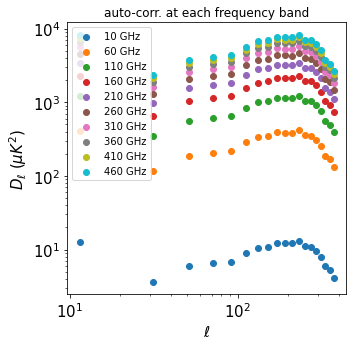

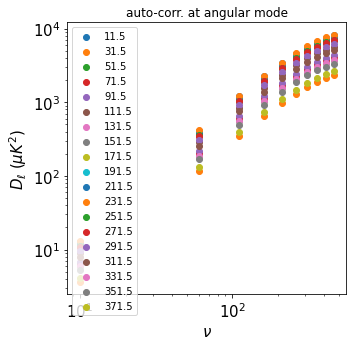

In [13]:
fig,ax = matplotlib.pyplot.subplots(figsize=(5,5))

for j in range(len(freq_sample)):
    ax.scatter(ellist,dust_ps[:,j,j],label=str(freq_sample[j])+' GHz')
    
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'$\ell$',fontsize=15)
ax.set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_title('auto-corr. at each frequency band')
ax.legend(loc=2)

fig,ax = matplotlib.pyplot.subplots(figsize=(5,5))

for i in range(len(ellist)):
    ax.scatter(freq_sample,np.diag(dust_ps[i]),label=str(ellist[i]))
    
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'$\nu$',fontsize=15)
ax.set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_title('auto-corr. at angular mode')
ax.legend(loc=2)

- synchrotron-dust correlated

$$ \mathcal{D}^{XX}_\ell(\nu_1,\nu_2) = \mathcal{A}^{XX}_{s,\ell} \left( \frac{\nu_1 \nu_2}{\nu^2_{0s}} \right)^{\beta_s} + \mathcal{A}^{XX}_{d,\ell} \left( \frac{\nu_1 \nu_2}{\nu^2_{0d}} \right)^{\beta_d-2} \frac{B_{\nu_1}(T_d)}{B_{\nu_0}(T_d)} \frac{B_{\nu_2}(T_d)}{B_{\nu_0}(T_d)} + \rho^{XX} \sqrt{\mathcal{A}^{XX}_{s,\ell}\mathcal{A}^{XX}_{d,\ell}} \left( (\frac{\nu_1}{\nu_{0s}})^{\beta_s}(\frac{\nu_2}{\nu_{0d}})^{\beta_d-2}\frac{B_{\nu_2}(T_d)}{B_{\nu_0}(T_d)} + (\frac{\nu_2}{\nu_{0s}})^{\beta_s}(\frac{\nu_1}{\nu_{0d}})^{\beta_d-2}\frac{B_{\nu_1}(T_d)}{B_{\nu_0}(T_d)}\right)$$

with Planck reference, $\nu_{0s} = 30$ GHz, $\nu_{0d} = 353$ GHz.

In [14]:
from abspy.tools.fg_models import syncdustmodel

In [15]:
c = syncdustmodel(ellist=list(ellist),freq_ref=[30.,353.])
print ('list of pre-defined parameter names')
c.param_list
# update dust PS template to model parameters
for i in range(len(ellist)):
    c.reset({c.param_list[i] : syncamp[i]})
    c.reset({c.param_list[i+len(ellist)] : dustamp[i]})

list of pre-defined parameter names


In [16]:
c.reset({'beta_d':1.})
c.reset({'beta_s':-2.})
c.reset({'rho':0.3})
c.reset({'xxx':100})
c.params

{'amp_s_11.5': 746.0074356825078,
 'amp_d_191.5': 6463.699957456511,
 'amp_d_11.5': 933.2833470261152,
 'amp_s_211.5': 1849.7639033229948,
 'amp_s_31.5': 1701.3605640786147,
 'amp_d_211.5': 2987.362967768661,
 'amp_d_31.5': 2038.8389502429752,
 'amp_s_231.5': 3285.1465812899282,
 'amp_s_51.5': 2427.329633617856,
 'amp_d_231.5': 3479.1402435239206,
 'amp_d_51.5': 2995.3825625488967,
 'amp_s_251.5': 4524.045818984944,
 'amp_s_71.5': 4132.004540635241,
 'amp_d_251.5': 5336.247101307117,
 'amp_d_71.5': 4098.265969090354,
 'amp_s_271.5': 5564.193803931675,
 'amp_s_91.5': 5003.471772366568,
 'amp_d_271.5': 6203.76514289824,
 'amp_d_91.5': 5237.676231486928,
 'amp_s_291.5': 6169.326883071628,
 'amp_s_111.5': 5480.780332201542,
 'amp_d_291.5': 6146.967098560228,
 'amp_d_111.5': 5668.938378988525,
 'amp_s_311.5': 6600.917748844759,
 'amp_s_131.5': 4948.897106263535,
 'amp_d_311.5': 5638.610014703122,
 'amp_d_131.5': 5011.257223428095,
 'amp_s_331.5': 5561.264184187214,
 'amp_s_151.5': 4338.6417

In [17]:
freq_sample = list(np.arange(10,500,50))
hybrid_ps = c.bandpower(freq_sample)
hybrid_ps.shape

(19, 10, 10)

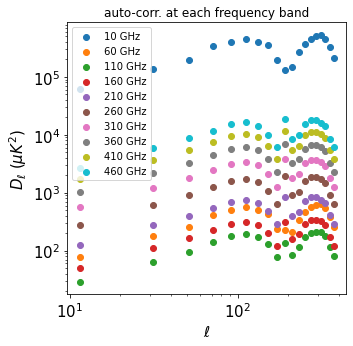

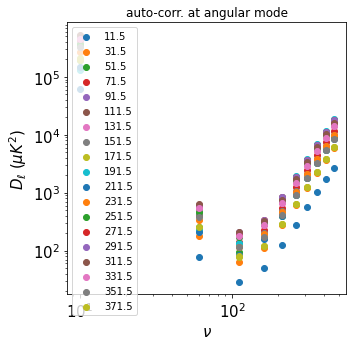

In [18]:
fig,ax = matplotlib.pyplot.subplots(figsize=(5,5))

for j in range(len(freq_sample)):
    ax.scatter(ellist,hybrid_ps[:,j,j],label=str(freq_sample[j])+' GHz')
    
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'$\ell$',fontsize=15)
ax.set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_title('auto-corr. at each frequency band')
ax.legend(loc=2)

fig,ax = matplotlib.pyplot.subplots(figsize=(5,5))

for i in range(len(ellist)):
    ax.scatter(freq_sample,np.diag(hybrid_ps[i]),label=str(ellist[i]))
    
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'$\nu$',fontsize=15)
ax.set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_title('auto-corr. at angular mode')
ax.legend(loc=2)

end